### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
path = "/home/yusuf/quant/drl-crypto/data/features/1s"
X = []
keys = []
for file in os.listdir(path):
    if file.endswith(".parquet"):
        df = pd.read_parquet(os.path.join(path, file))
        df = df.dropna().drop(columns=["price_last","buy_qty","sell_qty", "best_bid", "best_ask"])
        df = df.set_index("ts")
        X.append(df)
        keys.append(file.split("-")[0])
X = pd.concat(X, axis=1,keys=keys).sort_index().ffill().replace([np.inf,-np.inf],np.nan).dropna()
X.info()


Matplotlib is building the font cache; this may take a moment.


KeyboardInterrupt: 

In [ ]:
X.columns

MultiIndex([('BNBUSDT',                    'price_last'),
            ('BNBUSDT',                       'buy_qty'),
            ('BNBUSDT',                      'sell_qty'),
            ('BNBUSDT',                      'best_bid'),
            ('BNBUSDT',                      'best_ask'),
            ('BNBUSDT',        'log_ret_20_zscore_1200'),
            ('BNBUSDT',        'log_ret_60_zscore_3600'),
            ('BNBUSDT',      'log_ret_180_zscore_10800'),
            ('BNBUSDT',      'log_ret_600_zscore_36000'),
            ('BNBUSDT',    'log_ret_1800_zscore_108000'),
            ...
            ('ETHUSDT',     'log_volume_20_zscore_1200'),
            ('ETHUSDT',     'log_volume_60_zscore_3600'),
            ('ETHUSDT',   'log_volume_180_zscore_10800'),
            ('ETHUSDT',   'log_volume_600_zscore_36000'),
            ('ETHUSDT', 'log_volume_1800_zscore_108000'),
            ('ETHUSDT',            'ofi_20_zscore_1200'),
            ('ETHUSDT',            'ofi_60_zscore_3600')

array([[<Axes: title={'center': 'y'}>]], dtype=object)

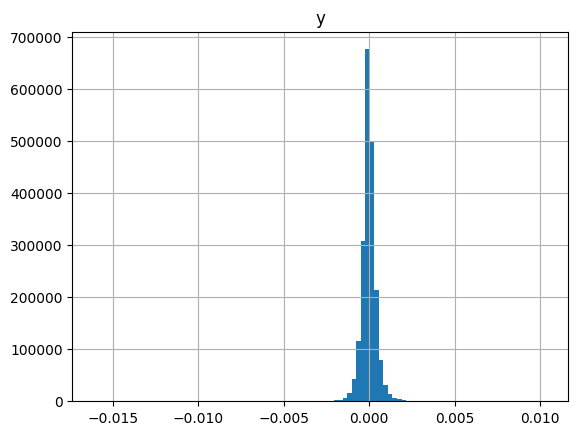

In [ ]:
y_path = "/home/yusuf/quant/drl-crypto/data/features/1s/BNBUSDT-1s-2025-05.parquet"
y = pd.read_parquet(y_path)


horizon = 30

y =pd.DataFrame(
    {
        "y": np.log(y.price_last).diff(-horizon),
        "ts" : y.ts
    }
).set_index("ts").replace([np.inf,-np.inf],np.nan).dropna()
y.hist(bins=100)

In [ ]:
y.quantile(0.1), y.quantile(0.9)

(y   -0.000466
 Name: 0.1, dtype: float64,
 y    0.000465
 Name: 0.9, dtype: float64)

In [ ]:

common_idx = y.index.intersection(X.index)
y= y.loc[common_idx]
X = X.loc[common_idx]
y = y.squeeze()  

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (1618932, 105), y_train shape: (1618932,)


In [ ]:
### OLS

In [ ]:

import statsmodels.api as sm

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     85.19
Date:                Fri, 13 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:52:36   Log-Likelihood:             1.0173e+07
No. Observations:             1618932   AIC:                        -2.035e+07
Df Residuals:                 1618826   BIC:                        -2.034e+07
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(sm.add_constant(X_test))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1.5602783377452696e-07
R^2 Score: 0.0015889117812040165


### XGB

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=20, 
    scoring='neg_mean_squared_error',
    cv=3,  
    verbose=1,
    random_state=42,
    n_jobs=10
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Best Parameters: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best Score: 2.0444078378403255e-07


In [ ]:
y_pred = random_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error after tuning: {mse}")
print(f"R^2 Score after tuning: {r2}")

Mean Squared Error after tuning: 1.5566151166201166e-07
R^2 Score after tuning: 0.0039329811061907805


In [ ]:
y_pred = pd.Series(y_pred, index=y_test.index, name='y_pred')
ys_test = pd.concat([y_test, y_pred], axis=1)
ys_test


,y,y_pred
ts,,
2025-05-25 16:41:52,-0.000919,-0.000001
2025-05-25 16:41:53,-0.000889,-0.000008
2025-05-25 16:41:54,-0.000859,-0.000012
2025-05-25 16:41:56,-0.000859,-0.000027
2025-05-25 16:41:59,-0.000874,-0.000028
...,...,...
2025-05-31 23:58:49,0.000213,0.000007
2025-05-31 23:58:51,0.000228,0.000008
2025-05-31 23:58:53,0.000228,0.000020


<Axes: title={'center': 'Predicted vs Actual for 2025-05-25'}, xlabel='ts'>

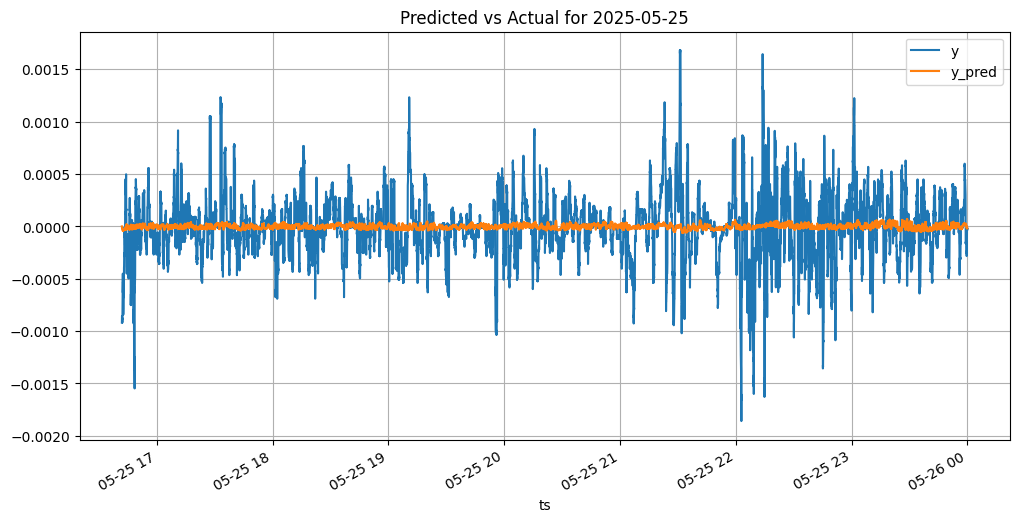

In [ ]:
day = ys_test.index.normalize().unique()[0].strftime('%Y-%m-%d')
ys_test.loc[day].plot(figsize=(12, 6), title=f"Predicted vs Actual for {day}", grid=True)

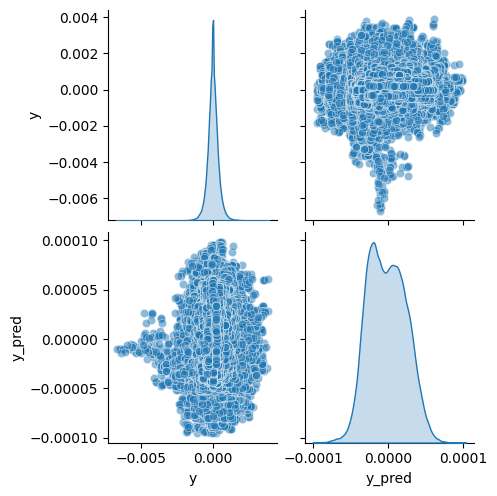

In [ ]:
import seaborn as sns

sns.pairplot(ys_test, diag_kind='kde', plot_kws={'alpha': 0.5})


In [ ]:
## getting the sign accuracy
from sklearn.metrics import accuracy_score
y_test_sign = np.sign(y_test)
y_pred_sign = np.sign(y_pred)
sign_accuracy = accuracy_score(y_test_sign, y_pred_sign)
print(f"Sign Accuracy: {sign_accuracy:.3f}")

Sign Accuracy: 0.506


<Axes: title={'center': 'Predictions vs Actuals'}, xlabel='ts'>

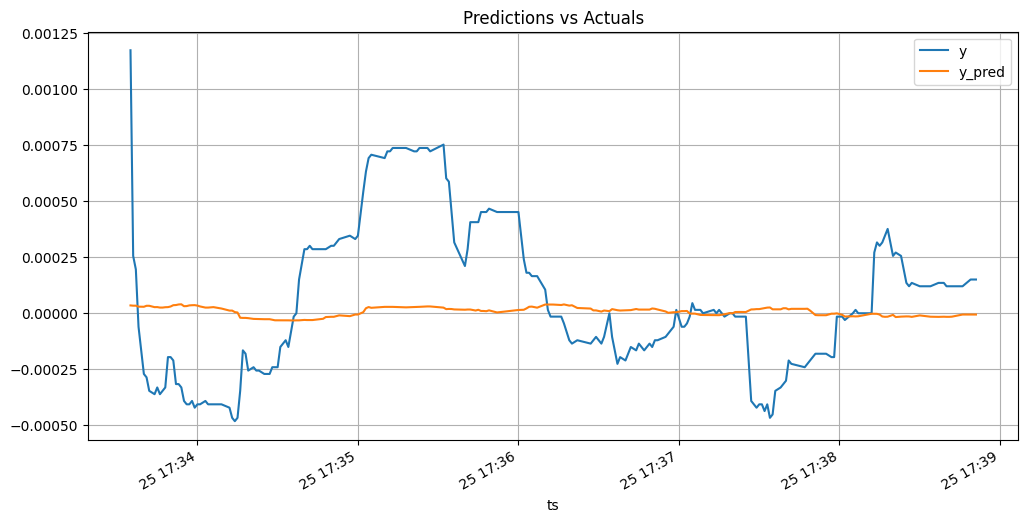

In [ ]:
i=2200
ys_test.iloc[i:i+200].plot(figsize=(12, 6), title="Predictions vs Actuals", grid=True)